In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os
from shutil import copyfile

In [2]:
import analysis as an

In [3]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('./output/lwr_only.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [4]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

Sink_Source_Inst has no values
Sink_Source_Inst has no values


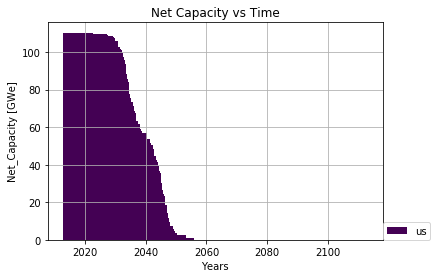

In [5]:
Image('power_plot.png')

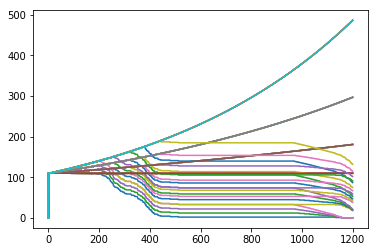

In [6]:

def get_dep_arrays(sfr_avail, growth_rate):
    # automatically calculated values
    scenario_name = '%i_%s_growth' %(sfr_avail, str(growth_rate).replace('.','_'))
    demand_eq = '110*(%s)**(t/12)' %str(1+growth_rate)
    avail_timestep = (sfr_avail* 12) - (2013*12 + 5)

    # get lwr_only, find deployment scheme for lwr and sfr
    cur = an.get_cursor('./output/lwr_only.sqlite')
    init_year, init_month, duration, timestep = an.get_timesteps(cur)
    power_dict = an.get_power_dict(cur)
    ################ TEMPORARILY #################
    # power_dict = {'us_government': np.append(power_dict['us_government'], np.zeros(500))}
    dep_array, dep_power = an.get_new_deployment(power_dict, ['us_government'],
                                                 demand_eq, 1, 960, avail_timestep, new=False)


    new_power = {'power': power_dict['us_government'] + dep_power}
    plt.plot(new_power['power'])
    sfr_dep, sfr_power = an.get_new_deployment(new_power, ['power'], demand_eq,
                                               0.4, 960, avail_timestep, True)
    plt.plot(new_power['power'] + sfr_power)
    return dep_array, sfr_dep


dep_dict = {}
for sfr_avail in [2030, 2035, 2040, 2045, 2050]:
    for growth_rate in [0.0, 0.005, 0.01, 0.015]:
        scenario_name = '%i_%s_growth' %(sfr_avail, str(growth_rate).replace('.','_'))
        lwr_dep, sfr_dep = get_dep_arrays(sfr_avail, growth_rate)
        dep_dict[scenario_name] = {'lwr': lwr_dep, 'sfr': sfr_dep}

In [8]:
# write these deploy schemes to file
for key in dep_dict.keys():
    if not os.path.isdir("./%s" %key):
        print('FOLDER %s NOT THERE,' %key)
        os.makedirs(key)    
        print('%s FOLDER MADE!' %key)
    try:
        os.remove('./%s/input.xml' %key)
    except:
        print('./%s/input.xml DOES NOT EXIST'%key)
    copyfile('./input.xml', './%s/input.xml' %key)
    an.write_deployinst(dep_dict[key]['lwr'], 'lwr', './%s/lwr_dep.xml' %key, 960)
    an.write_deployinst(dep_dict[key]['sfr'], 'sfr', './%s/sfr_dep.xml' %key, 960)
    an.write_deployinst(dep_dict[key]['sfr'], 'blanket', './%s/blanket_dep.xml' %key, 960)
